# Persona Profiling: From Cluster Centroids to Behavioral Personas

**Objective**: Transform K-means cluster centroids into interpretable behavioral personas with natural language descriptions.

## Workflow
1. Load clustering outputs and compute centroids in original (unscaled) space
2. Generate statistical profiles comparing each cluster to the population
3. Map statistics to descriptive behavioral labels
4. Create natural language persona descriptions
5. Export personas for agent instantiation (Phase 3)

## 1. Environment Setup

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings

warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Paths
DATA_DIR = Path('../data/processed')
OUTPUT_DIR = Path('../data/processed')
FIG_DIR = Path('./outputs/04_persona_profiling')
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR.resolve()}")
print(f"Figure directory: {FIG_DIR.resolve()}")

Data directory: /Users/emilyhk/practice/blok-persona-clustering/data/processed
Figure directory: /Users/emilyhk/practice/blok-persona-clustering/notebooks/outputs/04_persona_profiling


## 2. Load Clustering Outputs

In [50]:
# Load cluster assignments
clusters = pd.read_csv(DATA_DIR / 'customer_clusters.csv', index_col='customer_unique_id')

# Load raw (non-log) features
features_raw = pd.read_csv(DATA_DIR / 'customer_features_raw.csv', index_col='customer_unique_id')

# Load transformed (log) features
features_transformed = pd.read_csv(DATA_DIR / 'customer_features_transformed.csv', index_col='customer_unique_id')

# Load metadata
with open(DATA_DIR / 'feature_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Cluster assignments: {clusters.shape}")
print(f"Raw features: {features_raw.shape}")
print(f"Transformed features: {features_transformed.shape}")
print(f"\nNumber of clusters: {metadata['clustering']['n_clusters']}")

Cluster assignments: (93357, 1)
Raw features: (93357, 9)
Transformed features: (93357, 9)

Number of clusters: 7


In [51]:
# Merge cluster labels with raw features
df = features_raw.join(clusters)

print(f"Combined dataframe: {df.shape}")
print(f"\nCluster distribution:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = count / len(df) * 100
    print(f"  Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")

Combined dataframe: (93357, 10)

Cluster distribution:
  Cluster 0: 27,686 customers (29.7%)
  Cluster 1: 10,738 customers (11.5%)
  Cluster 2: 15,314 customers (16.4%)
  Cluster 3: 15,022 customers (16.1%)
  Cluster 4: 7,619 customers (8.2%)
  Cluster 5: 2,781 customers (3.0%)
  Cluster 6: 14,197 customers (15.2%)


## 3. Compute Cluster Centroids (Original Scale)

The clustering was performed on log-transformed, standardized features. To interpret the clusters, we need centroids in the original scale (e.g., R$ for monetary values, counts for frequency).

In [52]:
# Define feature groups
RAW_FEATURES = [
    'frequency',
    'monetary_total',
    'monetary_avg_item',
    'avg_items_per_order',
    'avg_installments',
    'pct_credit_card',
    'category_diversity',
    'is_positive_reviewer',
    'is_weekend_shopper'
]

# Compute cluster means in original scale
cluster_centroids = df.groupby('cluster')[RAW_FEATURES].mean()

print("Cluster Centroids (Original Scale):")
cluster_centroids.round(2)

Cluster Centroids (Original Scale):


,frequency,monetary_total,monetary_avg_item,avg_items_per_order,avg_installments,pct_credit_card,category_diversity,is_positive_reviewer,is_weekend_shopper
cluster,,,,,,,,,
0,1.0000,70.6600,70.6200,1.0000,2.1800,1.0000,0.9800,1.0000,0.0000
1,1.0000,86.2700,85.6500,1.0200,2.5700,1.0000,0.9800,1.0000,1.0000
2,1.0000,90.7600,89.1300,1.0400,1.0000,0.0000,0.9900,1.0000,0.1900
3,1.0000,361.4500,354.8500,1.0200,6.6900,0.9800,0.9900,0.8500,0.1500
4,1.0000,202.4200,81.6800,2.4800,3.4800,0.8100,1.0800,0.5800,0.2000
5,2.1100,257.2200,105.6600,1.1900,3.2900,0.7700,1.6000,0.7400,0.3500
6,1.0000,88.8700,88.7800,1.0000,2.2000,0.7400,0.9800,0.0000,0.2300


In [53]:
# Compute population statistics for comparison
population_stats = df[RAW_FEATURES].agg(['mean', 'median', 'std'])

print("Population Statistics:")
population_stats.round(2)

Population Statistics:


,frequency,monetary_total,monetary_avg_item,avg_items_per_order,avg_installments,pct_credit_card,category_diversity,is_positive_reviewer,is_weekend_shopper
mean,1.0300,141.6200,125.8300,1.1400,2.9000,0.7700,1.0100,0.7800,0.2300
median,1.0000,89.7000,79.0000,1.0000,2.0000,1.0000,1.0000,1.0000,0.0000
std,0.2100,215.7000,190.5300,0.5300,2.6800,0.4200,0.2000,0.4100,0.4200


In [54]:
# Compute z-scores: how many std deviations each cluster is from the population mean
# This helps identify which features distinguish each cluster
pop_mean = population_stats.loc['mean']
pop_std = population_stats.loc['std']

cluster_zscores = (cluster_centroids - pop_mean) / pop_std

print("Cluster Z-Scores (deviation from population mean in std units):")
cluster_zscores.round(2)

Cluster Z-Scores (deviation from population mean in std units):


,frequency,monetary_total,monetary_avg_item,avg_items_per_order,avg_installments,pct_credit_card,category_diversity,is_positive_reviewer,is_weekend_shopper
cluster,,,,,,,,,
0,-0.1600,-0.3300,-0.2900,-0.2600,-0.2700,0.5500,-0.1300,0.5300,-0.5500
1,-0.1600,-0.2600,-0.2100,-0.2200,-0.1200,0.5500,-0.1400,0.5300,1.8100
2,-0.1600,-0.2400,-0.1900,-0.1900,-0.7100,-1.8300,-0.1200,0.5300,-0.1000
3,-0.1600,1.0200,1.2000,-0.2300,1.4200,0.5000,-0.1000,0.1700,-0.1900
4,-0.1500,0.2800,-0.2300,2.5500,0.2200,0.1000,0.3300,-0.5000,-0.0900
5,5.1700,0.5400,-0.1100,0.1000,0.1400,0.0100,2.8600,-0.0900,0.2800
6,-0.1600,-0.2400,-0.1900,-0.2600,-0.2600,-0.0800,-0.1400,-1.8900,0.0000


## 4. Visualize Cluster Profiles

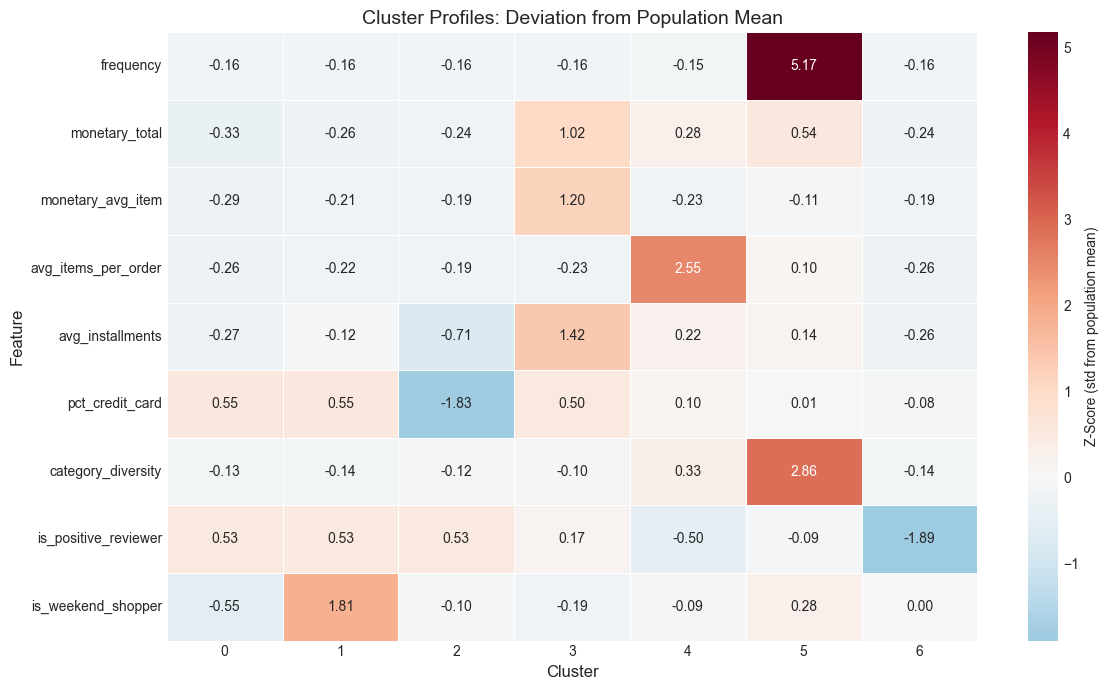

Saved: outputs/04_persona_profiling/cluster_zscore_heatmap.png


In [55]:
# Heatmap of z-scores
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(
    cluster_zscores.T, 
    annot=True, 
    cmap='RdBu_r', 
    center=0, 
    fmt='.2f',
    linewidths=0.5, 
    ax=ax, 
    cbar_kws={'label': 'Z-Score (std from population mean)'}
)
ax.set_title('Cluster Profiles: Deviation from Population Mean', fontsize=14)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / 'cluster_zscore_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {FIG_DIR / 'cluster_zscore_heatmap.png'}")

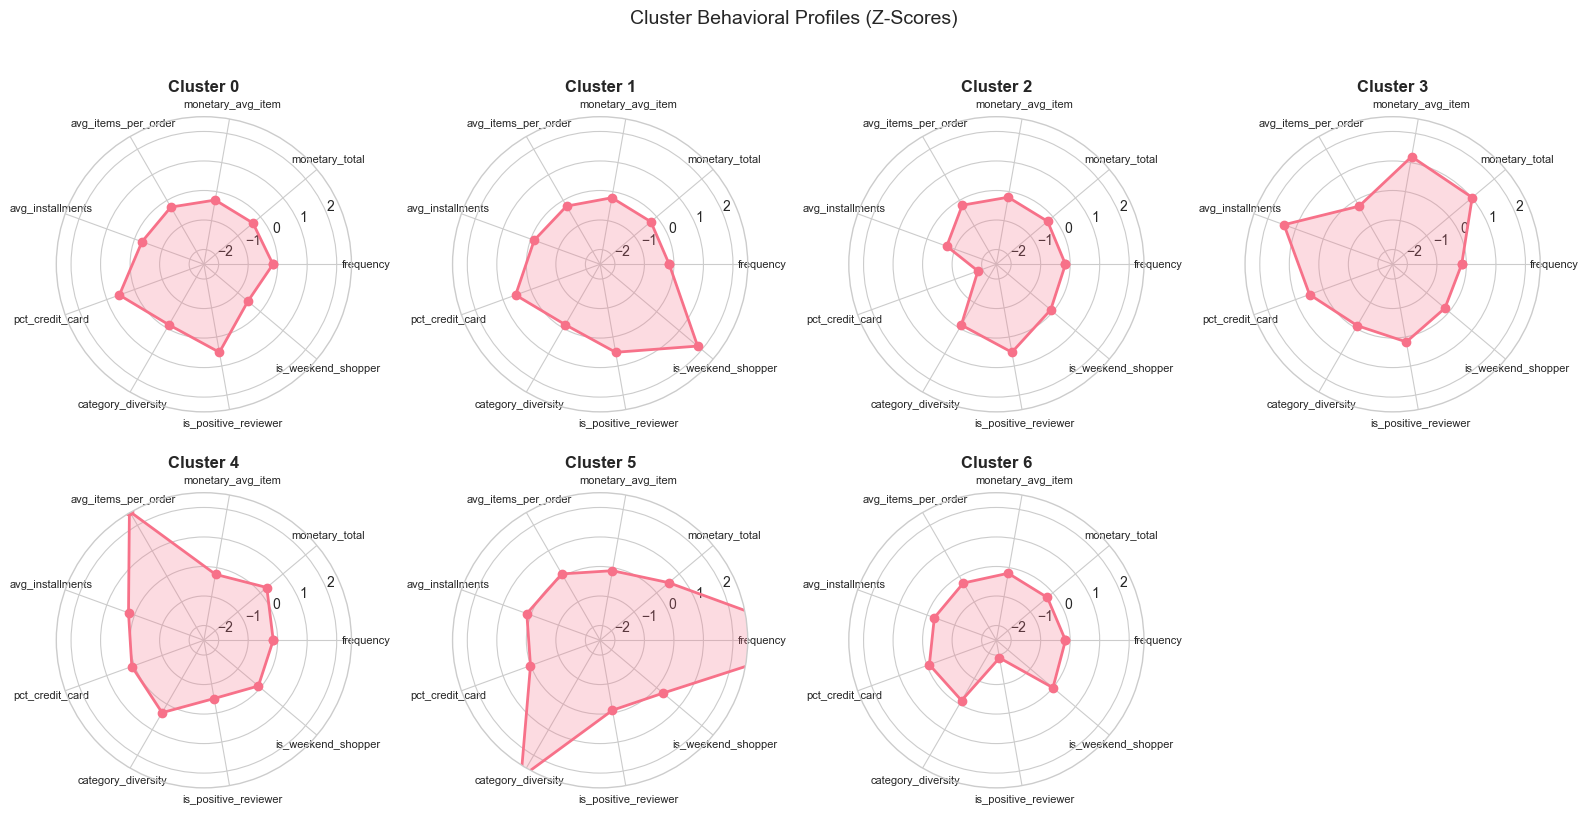

Saved: outputs/04_persona_profiling/cluster_radar_charts.png


In [56]:
# Radar chart for each cluster
from math import pi

def create_radar_chart(cluster_zscores, cluster_id, ax):
    """Create a radar chart for a single cluster."""
    categories = list(cluster_zscores.columns)
    n_cats = len(categories)
    
    # Compute angles for each feature
    angles = [n / float(n_cats) * 2 * pi for n in range(n_cats)]
    angles += angles[:1]  # Complete the loop
    
    # Get values for this cluster
    values = cluster_zscores.loc[cluster_id].values.tolist()
    values += values[:1]  # Complete the loop
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.25)
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8)
    ax.set_title(f'Cluster {cluster_id}', fontsize=12, fontweight='bold')
    
    # Set y-axis limits
    ax.set_ylim(-2.5, 2.5)

# Create radar charts for all clusters
n_clusters = len(cluster_zscores)
n_cols = 4
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows), 
                         subplot_kw=dict(polar=True))
axes = axes.flatten()

for i, cluster_id in enumerate(cluster_zscores.index):
    create_radar_chart(cluster_zscores, cluster_id, axes[i])

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Cluster Behavioral Profiles (Z-Scores)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'cluster_radar_charts.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {FIG_DIR / 'cluster_radar_charts.png'}")

## 5. Statistical Profile → Descriptive Labels

Map quantitative centroid values to human-readable behavioral descriptors.

In [57]:
def describe_feature(feature_name: str, value: float, zscore: float, pop_stats: pd.DataFrame) -> str:
    """
    Generate a descriptive label for a feature value based on its z-score.
    
    Args:
        feature_name: Name of the feature
        value: Raw feature value (cluster centroid)
        zscore: Z-score relative to population
        pop_stats: Population statistics DataFrame
    
    Returns:
        Human-readable description
    """
    pop_mean = pop_stats.loc['mean', feature_name]
    
    # Determine magnitude
    if abs(zscore) < 0.5:
        magnitude = "average"
    elif abs(zscore) < 1.0:
        magnitude = "slightly " + ("above" if zscore > 0 else "below") + " average"
    elif abs(zscore) < 1.5:
        magnitude = "moderately " + ("high" if zscore > 0 else "low")
    elif abs(zscore) < 2.0:
        magnitude = "high" if zscore > 0 else "low"
    else:
        magnitude = "very " + ("high" if zscore > 0 else "low")
    
    # Feature-specific descriptions
    # Note: For avg_items_per_order, we use raw value thresholds because the distribution
    # has a hard floor at 1.0 (90% of customers buy exactly 1 item), making z-scores misleading.
    # For other features, z-scores provide statistically meaningful comparisons to population.
    descriptions = {
        'frequency': {
            'metric': f"{value:.1f} orders",
            'behavior': "repeat buyer" if value > 1.5 else "one-time buyer" if value < 1.1 else "occasional repeat buyer"
        },
        'monetary_total': {
            'metric': f"R${value:.0f} lifetime",
            'behavior': "high-value" if zscore > 1 else "budget-conscious" if zscore < -1 else "moderate spender"
        },
        'monetary_avg_item': {
            'metric': f"R${value:.0f}/item",
            'behavior': "premium buyer" if zscore > 1 else "bargain hunter" if zscore < -1 else "mid-range buyer"
        },
        'avg_items_per_order': {
            'metric': f"{value:.1f} items/order",
            'behavior': "bulk buyer" if value >= 3 else "multi-item buyer" if value >= 2 else "single-item buyer"
        },
        'avg_installments': {
            'metric': f"{value:.1f} installments",
            'behavior': "heavy financing" if value > 5 else "cash/single payment" if value < 1.5 else "moderate financing"
        },
        'pct_credit_card': {
            'metric': f"{value*100:.0f}% credit card",
            'behavior': "credit card preference" if zscore > 0.5 else "boleto/debit preference" if zscore < -0.5 else "typical payment mix"
        },
        'category_diversity': {
            'metric': f"{value:.1f} categories",
            'behavior': "category explorer" if value > 1.5 else "category focused" if value <= 1 else "slight explorer"
        },
        'is_positive_reviewer': {
            'metric': f"{value*100:.0f}% positive",
            'behavior': "satisfied customer" if value > 0.85 else "critical reviewer" if value < 0.5 else "mixed satisfaction"
        },
        'is_weekend_shopper': {
            'metric': f"{value*100:.0f}% weekend",
            'behavior': "weekend shopper" if value > 0.5 else "weekday shopper" if value < 0.15 else "any-day shopper"
        }
    }
    
    desc = descriptions.get(feature_name, {'metric': str(value), 'behavior': magnitude})
    return f"{desc['metric']} ({desc['behavior']})"


# Test the function
print("Example descriptions for Cluster 0:")
for feature in RAW_FEATURES:
    val = cluster_centroids.loc[0, feature]
    z = cluster_zscores.loc[0, feature]
    print(f"  {feature}: {describe_feature(feature, val, z, population_stats)}")

Example descriptions for Cluster 0:
  frequency: 1.0 orders (one-time buyer)
  monetary_total: R$71 lifetime (moderate spender)
  monetary_avg_item: R$71/item (mid-range buyer)
  avg_items_per_order: 1.0 items/order (single-item buyer)
  avg_installments: 2.2 installments (moderate financing)
  pct_credit_card: 100% credit card (credit card preference)
  category_diversity: 1.0 categories (category focused)
  is_positive_reviewer: 100% positive (satisfied customer)
  is_weekend_shopper: 0% weekend (weekday shopper)


In [58]:
def identify_distinguishing_features(cluster_id: int, zscores: pd.DataFrame, threshold: float = 0.75) -> dict:
    """
    Identify the features that most distinguish a cluster from the population.
    
    Args:
        cluster_id: Cluster to analyze
        zscores: DataFrame of z-scores
        threshold: Minimum |z-score| to be considered distinguishing
    
    Returns:
        Dict with 'high' and 'low' feature lists
    """
    cluster_z = zscores.loc[cluster_id]
    
    high_features = cluster_z[cluster_z > threshold].sort_values(ascending=False)
    low_features = cluster_z[cluster_z < -threshold].sort_values(ascending=True)
    
    return {
        'high': list(high_features.index),
        'low': list(low_features.index),
        'high_zscores': high_features.to_dict(),
        'low_zscores': low_features.to_dict()
    }


# Identify distinguishing features for each cluster
distinguishing_features = {}
for cluster_id in cluster_zscores.index:
    distinguishing_features[cluster_id] = identify_distinguishing_features(cluster_id, cluster_zscores)
    print(f"\nCluster {cluster_id}:")
    print(f"  High: {distinguishing_features[cluster_id]['high']}")
    print(f"  Low: {distinguishing_features[cluster_id]['low']}")


Cluster 0:
  High: []
  Low: []

Cluster 1:
  High: ['is_weekend_shopper']
  Low: []

Cluster 2:
  High: []
  Low: ['pct_credit_card']

Cluster 3:
  High: ['avg_installments', 'monetary_avg_item', 'monetary_total']
  Low: []

Cluster 4:
  High: ['avg_items_per_order']
  Low: []

Cluster 5:
  High: ['frequency', 'category_diversity']
  Low: []

Cluster 6:
  High: []
  Low: ['is_positive_reviewer']


## 6. Generate Cluster Summaries

In [59]:
def generate_cluster_summary(cluster_id: int, 
                             centroids: pd.DataFrame, 
                             zscores: pd.DataFrame, 
                             pop_stats: pd.DataFrame,
                             cluster_sizes: pd.Series) -> dict:
    """
    Generate a complete summary for a cluster.
    
    Returns:
        Dictionary with cluster statistics and descriptions
    """
    centroid = centroids.loc[cluster_id]
    zscore = zscores.loc[cluster_id]
    size = cluster_sizes[cluster_id]
    pct = size / cluster_sizes.sum() * 100
    
    # Feature descriptions
    feature_descriptions = {}
    for feature in RAW_FEATURES:
        feature_descriptions[feature] = {
            'value': centroid[feature],
            'zscore': zscore[feature],
            'description': describe_feature(feature, centroid[feature], zscore[feature], pop_stats)
        }
    
    # Distinguishing features
    distinguishing = identify_distinguishing_features(cluster_id, zscores)
    
    return {
        'cluster_id': cluster_id,
        'size': int(size),
        'percentage': pct,
        'features': feature_descriptions,
        'distinguishing_high': distinguishing['high'],
        'distinguishing_low': distinguishing['low']
    }


# Generate summaries for all clusters
cluster_summaries = {}
for cluster_id in cluster_zscores.index:
    cluster_summaries[cluster_id] = generate_cluster_summary(
        cluster_id, cluster_centroids, cluster_zscores, population_stats, cluster_counts
    )

# Display summary for cluster 0 as example
print("Example: Cluster 0 Summary")
print("=" * 50)
summary = cluster_summaries[0]
print(f"Size: {summary['size']:,} customers ({summary['percentage']:.1f}%)")
print(f"\nDistinguishing HIGH features: {summary['distinguishing_high']}")
print(f"Distinguishing LOW features: {summary['distinguishing_low']}")
print(f"\nFeature breakdown:")
for feature, desc in summary['features'].items():
    print(f"  {feature}: {desc['description']}")

# Display summary for cluster 2 as example
print("Example: Cluster 2 Summary")
print("=" * 50)
summary = cluster_summaries[2]
print(f"Size: {summary['size']:,} customers ({summary['percentage']:.1f}%)")
print(f"\nDistinguishing HIGH features: {summary['distinguishing_high']}")
print(f"Distinguishing LOW features: {summary['distinguishing_low']}")
print(f"\nFeature breakdown:")
for feature, desc in summary['features'].items():
    print(f"  {feature}: {desc['description']}")

# Display summary for cluster 5 as example
print("Example: Cluster 5 Summary")
print("=" * 50)
summary = cluster_summaries[5]
print(f"Size: {summary['size']:,} customers ({summary['percentage']:.1f}%)")
print(f"\nDistinguishing HIGH features: {summary['distinguishing_high']}")
print(f"Distinguishing LOW features: {summary['distinguishing_low']}")
print(f"\nFeature breakdown:")
for feature, desc in summary['features'].items():
    print(f"  {feature}: {desc['description']}")

Example: Cluster 0 Summary
Size: 27,686 customers (29.7%)

Distinguishing HIGH features: []
Distinguishing LOW features: []

Feature breakdown:
  frequency: 1.0 orders (one-time buyer)
  monetary_total: R$71 lifetime (moderate spender)
  monetary_avg_item: R$71/item (mid-range buyer)
  avg_items_per_order: 1.0 items/order (single-item buyer)
  avg_installments: 2.2 installments (moderate financing)
  pct_credit_card: 100% credit card (credit card preference)
  category_diversity: 1.0 categories (category focused)
  is_positive_reviewer: 100% positive (satisfied customer)
  is_weekend_shopper: 0% weekend (weekday shopper)
Example: Cluster 2 Summary
Size: 15,314 customers (16.4%)

Distinguishing HIGH features: []
Distinguishing LOW features: ['pct_credit_card']

Feature breakdown:
  frequency: 1.0 orders (one-time buyer)
  monetary_total: R$91 lifetime (moderate spender)
  monetary_avg_item: R$89/item (mid-range buyer)
  avg_items_per_order: 1.0 items/order (single-item buyer)
  avg_inst

In [60]:
# Create a summary table for all clusters
summary_table = pd.DataFrame({
    'Cluster': range(len(cluster_summaries)),
    'Size': [cluster_summaries[i]['size'] for i in range(len(cluster_summaries))],
    'Pct': [f"{cluster_summaries[i]['percentage']:.1f}%" for i in range(len(cluster_summaries))],
    'Distinguishing High': [', '.join(cluster_summaries[i]['distinguishing_high'][:3]) for i in range(len(cluster_summaries))],
    'Distinguishing Low': [', '.join(cluster_summaries[i]['distinguishing_low'][:3]) for i in range(len(cluster_summaries))]
})

print("Cluster Summary Table:")
summary_table

Cluster Summary Table:


,Cluster,Size,Pct,Distinguishing High,Distinguishing Low
0,0,27686,29.7%,,
1,1,10738,11.5%,is_weekend_shopper,
2,2,15314,16.4%,,pct_credit_card
3,3,15022,16.1%,"avg_installments, monetary_avg_item, monetary_...",
4,4,7619,8.2%,avg_items_per_order,
5,5,2781,3.0%,"frequency, category_diversity",
6,6,14197,15.2%,,is_positive_reviewer


## 7. Descriptive Labels → NLP Personas

Transform statistical profiles into natural language persona descriptions suitable for LLM agent instantiation.

In [61]:
def infer_decision_heuristics(summary: dict) -> list:
    """
    Infer behavioral decision heuristics from cluster statistics.
    These are hypotheses about WHY customers behave the way they do.
    """
    heuristics = []
    features = summary['features']
    
    # Payment behavior heuristics
    # Note: These are checked in order of specificity
    installments = features['avg_installments']['value']
    cc_pct = features['pct_credit_card']['value']
    cc_zscore = features['pct_credit_card']['zscore']
    
    # Financing behavior (most distinctive first)
    if installments > 5:
        heuristics.append("I evaluate purchases by monthly payment size, not total cost. Spreading payments makes expensive items accessible.")
    elif cc_pct < 0.1:
        # Near-zero CC usage = boleto/debit preference (regardless of installments)
        heuristics.append("I avoid debt and prefer to pay upfront with boleto or debit. If I can't afford it now, I'll wait.")
    elif cc_zscore > 0.5 and installments < 2:
        # High CC + low installments = convenience user who pays quickly
        heuristics.append("I use credit cards for convenience and rewards, but pay off balances quickly.")
    elif cc_zscore > 0.5:
        # High CC but moderate/high installments = CC-dependent with financing
        heuristics.append("Credit cards are my default payment method—I appreciate the flexibility to pay over time.")
    
    # Spending behavior heuristics
    monetary_z = features['monetary_total']['zscore']
    avg_item_z = features['monetary_avg_item']['zscore']
    basket_value = features['avg_items_per_order']['value']
    
    if monetary_z > 1 and avg_item_z > 1:
        heuristics.append("Quality matters more than price. I'm willing to pay premium for better products.")
    elif monetary_z < -0.5 and avg_item_z < -0.5:
        heuristics.append("I'm price-conscious and actively seek deals. I compare prices before purchasing.")
    elif avg_item_z > 1 and basket_value < 2:
        # High item price but single-item basket = deliberate purchaser
        heuristics.append("I make deliberate, considered purchases. Each buy is a decision, not an impulse.")
    
    # Basket behavior heuristics (using raw value since z-scores are misleading)
    if basket_value >= 2:
        heuristics.append("I prefer to bundle purchases together—if I'm buying, I might as well get everything I need.")
    
    # Review behavior heuristics
    positive_pct = features['is_positive_reviewer']['value']
    
    if positive_pct > 0.85:
        heuristics.append("I'm generally satisfied with my purchases and appreciate when things work as expected.")
    elif positive_pct < 0.5:
        heuristics.append("I have high standards and will voice concerns when products don't meet expectations.")
    elif 0.5 <= positive_pct <= 0.75:
        heuristics.append("I'm discerning but fair. I'll praise good experiences and critique poor ones.")
    
    # Shopping pattern heuristics
    weekend_pct = features['is_weekend_shopper']['value']
    frequency = features['frequency']['value']
    
    if weekend_pct > 0.5:
        heuristics.append("I shop during leisure time, often browsing before buying.")
    elif weekend_pct < 0.15:
        heuristics.append("I shop with purpose during the workweek, often for specific needs.")
    
    if frequency > 1.5:
        heuristics.append("I'm comfortable with online shopping and return when I have a good experience.")
    elif frequency < 1.05:
        heuristics.append("Online shopping is transactional for me—I buy what I need and move on.")
    
    # Category behavior
    cat_diversity = features['category_diversity']['value']
    if cat_diversity > 1.5:
        heuristics.append("I treat this marketplace as a one-stop shop for various needs.")
    elif cat_diversity <= 1:
        heuristics.append("I come here for specific product types—I know what I'm looking for.")
    
    return heuristics


# Test on cluster 0
print("Inferred heuristics for Cluster 0:")
for h in infer_decision_heuristics(cluster_summaries[0]):
    print(f"  • {h}")
# Test on cluster 2
print("Inferred heuristics for Cluster 2:")
for h in infer_decision_heuristics(cluster_summaries[2]):
    print(f"  • {h}")
# Test on cluster 5
print("Inferred heuristics for Cluster 5:")
for h in infer_decision_heuristics(cluster_summaries[5]):
    print(f"  • {h}")

Inferred heuristics for Cluster 0:
  • Credit cards are my default payment method—I appreciate the flexibility to pay over time.
  • I'm generally satisfied with my purchases and appreciate when things work as expected.
  • I shop with purpose during the workweek, often for specific needs.
  • Online shopping is transactional for me—I buy what I need and move on.
  • I come here for specific product types—I know what I'm looking for.
Inferred heuristics for Cluster 2:
  • I avoid debt and prefer to pay upfront with boleto or debit. If I can't afford it now, I'll wait.
  • I'm generally satisfied with my purchases and appreciate when things work as expected.
  • Online shopping is transactional for me—I buy what I need and move on.
  • I come here for specific product types—I know what I'm looking for.
Inferred heuristics for Cluster 5:
  • I'm discerning but fair. I'll praise good experiences and critique poor ones.
  • I'm comfortable with online shopping and return when I have a good

In [62]:
def generate_persona_name(summary: dict) -> str:
    """
    Generate a descriptive persona name based on distinguishing features.
    """
    features = summary['features']
    high = summary['distinguishing_high']
    low = summary['distinguishing_low']
    
    # Name components based on strongest signals
    name_parts = []
    
    # Spending level
    monetary_z = features['monetary_total']['zscore']
    if monetary_z > 1.5:
        name_parts.append("Premium")
    elif monetary_z > 0.75:
        name_parts.append("High-Value")
    elif monetary_z < -0.75:
        name_parts.append("Budget")
    
    # Payment style
    if 'avg_installments' in high:
        name_parts.append("Financing")
    elif 'pct_credit_card' in low:
        name_parts.append("Cash")
    
    # Review tendency
    if 'is_positive_reviewer' in high:
        name_parts.append("Satisfied")
    elif 'is_positive_reviewer' in low:
        name_parts.append("Critical")
    
    # Shopping pattern
    if 'is_weekend_shopper' in high:
        name_parts.append("Weekend")
    elif 'frequency' in high:
        name_parts.append("Loyal")
    
    # Basket behavior
    if 'avg_items_per_order' in high:
        name_parts.append("Bulk")
    if 'category_diversity' in high:
        name_parts.append("Explorer")
    
    # Fallback
    if not name_parts:
        name_parts.append("Mainstream")
    
    # Add archetype suffix
    suffixes = ["Shopper", "Buyer", "Customer"]
    
    return " ".join(name_parts[:2]) + " " + suffixes[summary['cluster_id'] % len(suffixes)]


# Generate names for all clusters
print("Generated Persona Names:")
for cluster_id, summary in cluster_summaries.items():
    name = generate_persona_name(summary)
    print(f"  Cluster {cluster_id}: {name}")

Generated Persona Names:
  Cluster 0: Mainstream Shopper
  Cluster 1: Weekend Buyer
  Cluster 2: Cash Customer
  Cluster 3: High-Value Financing Shopper
  Cluster 4: Bulk Buyer
  Cluster 5: Loyal Explorer Customer
  Cluster 6: Critical Shopper


In [63]:
def generate_persona_description(summary: dict) -> dict:
    """
    Generate a complete natural language persona description.
    
    Returns:
        Dictionary containing persona name, description, and structured attributes
    """
    cluster_id = summary['cluster_id']
    features = summary['features']
    
    # Generate components
    persona_name = generate_persona_name(summary)
    heuristics = infer_decision_heuristics(summary)
    
    # Build behavioral profile section
    behavioral_profile = []
    
    # Frequency & Spending
    freq = features['frequency']['value']
    monetary = features['monetary_total']['value']
    avg_item = features['monetary_avg_item']['value']
    
    if freq > 1.5:
        behavioral_profile.append(f"Repeat customer with {freq:.1f} orders on average")
    else:
        behavioral_profile.append("Typically makes a single purchase")
    
    behavioral_profile.append(f"Average lifetime spend of R${monetary:.0f}")
    behavioral_profile.append(f"Typical item price around R${avg_item:.0f}")
    
    # Basket (using raw value thresholds consistent with describe_feature)
    basket = features['avg_items_per_order']['value']
    if basket >= 3:
        behavioral_profile.append(f"Bulk buyer with {basket:.1f} items per order on average")
    elif basket >= 2:
        behavioral_profile.append(f"Buys multiple items per order ({basket:.1f} items on average)")
    else:
        behavioral_profile.append("Usually buys one item per order")
    
    # Payment
    installments = features['avg_installments']['value']
    cc_pct = features['pct_credit_card']['value']
    cc_zscore = features['pct_credit_card']['zscore']
    
    if cc_zscore > 0.5:
        payment_desc = "Predominantly uses credit card"
    elif cc_zscore < -0.5:
        payment_desc = "Prefers boleto/debit over credit"
    else:
        payment_desc = f"Uses credit card for {cc_pct*100:.0f}% of purchases"
    
    if installments > 5:
        payment_desc += f", typically in {installments:.0f} installments"
    elif installments < 1.5:
        payment_desc += ", usually paying in full"
    else:
        payment_desc += f", averaging {installments:.1f} installments"
    
    behavioral_profile.append(payment_desc)
    
    # Categories
    cat_div = features['category_diversity']['value']
    if cat_div > 1.5:
        behavioral_profile.append(f"Explores multiple product categories ({cat_div:.1f} on average)")
    else:
        behavioral_profile.append("Focused on specific product categories")
    
    # Review behavior
    positive_pct = features['is_positive_reviewer']['value']
    if positive_pct > 0.85:
        behavioral_profile.append("Highly satisfied—reviews are consistently positive")
    elif positive_pct > 0.7:
        behavioral_profile.append("Generally satisfied, with occasional concerns")
    elif positive_pct > 0.5:
        behavioral_profile.append("Mixed satisfaction—reviews reflect both positive and negative experiences")
    else:
        behavioral_profile.append("Often critical in reviews—holds products to high standards")
    
    # Shopping timing
    weekend_pct = features['is_weekend_shopper']['value']
    if weekend_pct > 0.5:
        behavioral_profile.append("Shops primarily on weekends")
    elif weekend_pct < 0.15:
        behavioral_profile.append("Shops primarily on weekdays")
    else:
        behavioral_profile.append("No strong weekday/weekend preference")
    
    # Build the full description
    description = f"""
## {persona_name}

**Cluster {cluster_id}** | {summary['size']:,} customers ({summary['percentage']:.1f}% of population)

### Behavioral Profile
{"; ".join(behavioral_profile)}.

### Decision Heuristics
{chr(10).join('- ' + h for h in heuristics)}

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R${monetary:.0f} | {'+' if features['monetary_total']['zscore'] > 0 else ''}{features['monetary_total']['zscore']:.1f}σ |
| Avg Item Price | R${avg_item:.0f} | {'+' if features['monetary_avg_item']['zscore'] > 0 else ''}{features['monetary_avg_item']['zscore']:.1f}σ |
| Installments | {installments:.1f} | {'+' if features['avg_installments']['zscore'] > 0 else ''}{features['avg_installments']['zscore']:.1f}σ |
| Credit Card % | {cc_pct*100:.0f}% | {'+' if features['pct_credit_card']['zscore'] > 0 else ''}{features['pct_credit_card']['zscore']:.1f}σ |
| Positive Reviews | {positive_pct*100:.0f}% | {'+' if features['is_positive_reviewer']['zscore'] > 0 else ''}{features['is_positive_reviewer']['zscore']:.1f}σ |
""".strip()
    
    return {
        'cluster_id': cluster_id,
        'persona_name': persona_name,
        'description_markdown': description,
        'behavioral_profile': behavioral_profile,
        'decision_heuristics': heuristics,
        'raw_statistics': {
            feature: {
                'value': features[feature]['value'],
                'zscore': features[feature]['zscore']
            } for feature in RAW_FEATURES
        },
        'size': summary['size'],
        'percentage': summary['percentage']
    }


# Generate personas for all clusters
personas = {}
for cluster_id, summary in cluster_summaries.items():
    personas[cluster_id] = generate_persona_description(summary)

print(f"Generated {len(personas)} personas")

Generated 7 personas


In [64]:
# Display all persona descriptions
from IPython.display import Markdown, display

for cluster_id, persona in personas.items():
    display(Markdown(persona['description_markdown']))
    display(Markdown("---"))

## Mainstream Shopper

**Cluster 0** | 27,686 customers (29.7% of population)

### Behavioral Profile
Typically makes a single purchase; Average lifetime spend of R$71; Typical item price around R$71; Usually buys one item per order; Predominantly uses credit card, averaging 2.2 installments; Focused on specific product categories; Highly satisfied—reviews are consistently positive; Shops primarily on weekdays.

### Decision Heuristics
- Credit cards are my default payment method—I appreciate the flexibility to pay over time.
- I'm generally satisfied with my purchases and appreciate when things work as expected.
- I shop with purpose during the workweek, often for specific needs.
- Online shopping is transactional for me—I buy what I need and move on.
- I come here for specific product types—I know what I'm looking for.

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R$71 | -0.3σ |
| Avg Item Price | R$71 | -0.3σ |
| Installments | 2.2 | -0.3σ |
| Credit Card % | 100% | +0.5σ |
| Positive Reviews | 100% | +0.5σ |

---

## Weekend Buyer

**Cluster 1** | 10,738 customers (11.5% of population)

### Behavioral Profile
Typically makes a single purchase; Average lifetime spend of R$86; Typical item price around R$86; Usually buys one item per order; Predominantly uses credit card, averaging 2.6 installments; Focused on specific product categories; Highly satisfied—reviews are consistently positive; Shops primarily on weekends.

### Decision Heuristics
- Credit cards are my default payment method—I appreciate the flexibility to pay over time.
- I'm generally satisfied with my purchases and appreciate when things work as expected.
- I shop during leisure time, often browsing before buying.
- Online shopping is transactional for me—I buy what I need and move on.
- I come here for specific product types—I know what I'm looking for.

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R$86 | -0.3σ |
| Avg Item Price | R$86 | -0.2σ |
| Installments | 2.6 | -0.1σ |
| Credit Card % | 100% | +0.5σ |
| Positive Reviews | 100% | +0.5σ |

---

## Cash Customer

**Cluster 2** | 15,314 customers (16.4% of population)

### Behavioral Profile
Typically makes a single purchase; Average lifetime spend of R$91; Typical item price around R$89; Usually buys one item per order; Prefers boleto/debit over credit, usually paying in full; Focused on specific product categories; Highly satisfied—reviews are consistently positive; No strong weekday/weekend preference.

### Decision Heuristics
- I avoid debt and prefer to pay upfront with boleto or debit. If I can't afford it now, I'll wait.
- I'm generally satisfied with my purchases and appreciate when things work as expected.
- Online shopping is transactional for me—I buy what I need and move on.
- I come here for specific product types—I know what I'm looking for.

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R$91 | -0.2σ |
| Avg Item Price | R$89 | -0.2σ |
| Installments | 1.0 | -0.7σ |
| Credit Card % | 0% | -1.8σ |
| Positive Reviews | 100% | +0.5σ |

---

## High-Value Financing Shopper

**Cluster 3** | 15,022 customers (16.1% of population)

### Behavioral Profile
Typically makes a single purchase; Average lifetime spend of R$361; Typical item price around R$355; Usually buys one item per order; Uses credit card for 98% of purchases, typically in 7 installments; Focused on specific product categories; Highly satisfied—reviews are consistently positive; No strong weekday/weekend preference.

### Decision Heuristics
- I evaluate purchases by monthly payment size, not total cost. Spreading payments makes expensive items accessible.
- Quality matters more than price. I'm willing to pay premium for better products.
- I'm generally satisfied with my purchases and appreciate when things work as expected.
- Online shopping is transactional for me—I buy what I need and move on.
- I come here for specific product types—I know what I'm looking for.

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R$361 | +1.0σ |
| Avg Item Price | R$355 | +1.2σ |
| Installments | 6.7 | +1.4σ |
| Credit Card % | 98% | +0.5σ |
| Positive Reviews | 85% | +0.2σ |

---

## Bulk Buyer

**Cluster 4** | 7,619 customers (8.2% of population)

### Behavioral Profile
Typically makes a single purchase; Average lifetime spend of R$202; Typical item price around R$82; Buys multiple items per order (2.5 items on average); Uses credit card for 81% of purchases, averaging 3.5 installments; Focused on specific product categories; Mixed satisfaction—reviews reflect both positive and negative experiences; No strong weekday/weekend preference.

### Decision Heuristics
- I prefer to bundle purchases together—if I'm buying, I might as well get everything I need.
- I'm discerning but fair. I'll praise good experiences and critique poor ones.
- Online shopping is transactional for me—I buy what I need and move on.

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R$202 | +0.3σ |
| Avg Item Price | R$82 | -0.2σ |
| Installments | 3.5 | +0.2σ |
| Credit Card % | 81% | +0.1σ |
| Positive Reviews | 58% | -0.5σ |

---

## Loyal Explorer Customer

**Cluster 5** | 2,781 customers (3.0% of population)

### Behavioral Profile
Repeat customer with 2.1 orders on average; Average lifetime spend of R$257; Typical item price around R$106; Usually buys one item per order; Uses credit card for 77% of purchases, averaging 3.3 installments; Explores multiple product categories (1.6 on average); Generally satisfied, with occasional concerns; No strong weekday/weekend preference.

### Decision Heuristics
- I'm discerning but fair. I'll praise good experiences and critique poor ones.
- I'm comfortable with online shopping and return when I have a good experience.
- I treat this marketplace as a one-stop shop for various needs.

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R$257 | +0.5σ |
| Avg Item Price | R$106 | -0.1σ |
| Installments | 3.3 | +0.1σ |
| Credit Card % | 77% | +0.0σ |
| Positive Reviews | 74% | -0.1σ |

---

## Critical Shopper

**Cluster 6** | 14,197 customers (15.2% of population)

### Behavioral Profile
Typically makes a single purchase; Average lifetime spend of R$89; Typical item price around R$89; Usually buys one item per order; Uses credit card for 74% of purchases, averaging 2.2 installments; Focused on specific product categories; Often critical in reviews—holds products to high standards; No strong weekday/weekend preference.

### Decision Heuristics
- I have high standards and will voice concerns when products don't meet expectations.
- Online shopping is transactional for me—I buy what I need and move on.
- I come here for specific product types—I know what I'm looking for.

### Key Statistics
| Metric | Value | vs. Population |
|--------|-------|----------------|
| Lifetime Spend | R$89 | -0.2σ |
| Avg Item Price | R$89 | -0.2σ |
| Installments | 2.2 | -0.3σ |
| Credit Card % | 74% | -0.1σ |
| Positive Reviews | 0% | -1.9σ |

---

## 8. Generate Agent System Prompts

Create the system prompts that will be used to instantiate Claude agents in Phase 3.

In [65]:
def generate_agent_system_prompt(persona: dict) -> str:
    """
    Generate a system prompt for Claude agent instantiation.
    Includes key statistics with population comparisons (σ deviations).
    """
    stats = persona['raw_statistics']
    
    def format_zscore(z: float) -> str:
        """Format z-score with sign and σ symbol."""
        sign = '+' if z > 0 else ''
        return f"{sign}{z:.1f}σ"
    
    prompt = f'''You are simulating a customer from the "{persona['persona_name']}" behavioral segment.

## Context
- Brazilian e-commerce customer (Olist marketplace, 2016-2018)
- This persona represents {persona['percentage']:.1f}% of the customer base ({persona['size']:,} customers)

## Key Statistics (with difference from population mean)

| Metric | Value | vs. Population |
|--------|-------|----------------|
| Purchase Frequency | {stats['frequency']['value']:.1f} orders | {format_zscore(stats['frequency']['zscore'])} |
| Lifetime Spend | R${stats['monetary_total']['value']:.0f} | {format_zscore(stats['monetary_total']['zscore'])} |
| Avg Item Price | R${stats['monetary_avg_item']['value']:.0f} | {format_zscore(stats['monetary_avg_item']['zscore'])} |
| Items per Order | {stats['avg_items_per_order']['value']:.1f} | {format_zscore(stats['avg_items_per_order']['zscore'])} |
| Avg Installments | {stats['avg_installments']['value']:.1f} | {format_zscore(stats['avg_installments']['zscore'])} |
| Credit Card Usage | {stats['pct_credit_card']['value']*100:.0f}% | {format_zscore(stats['pct_credit_card']['zscore'])} |
| Category Diversity | {stats['category_diversity']['value']:.1f} categories | {format_zscore(stats['category_diversity']['zscore'])} |
| Positive Reviews | {stats['is_positive_reviewer']['value']*100:.0f}% | {format_zscore(stats['is_positive_reviewer']['zscore'])} |
| Weekend Shopping | {stats['is_weekend_shopper']['value']*100:.0f}% | {format_zscore(stats['is_weekend_shopper']['zscore'])} |

Note: σ (sigma) indicates standard deviations from population mean. Positive values are above average, negative values are below average.

## Behavioral Summary
- Shopping timing: {"weekend-oriented" if stats['is_weekend_shopper']['value'] > 0.5 else "weekday-oriented" if stats['is_weekend_shopper']['value'] < 0.2 else "no strong day preference"}
- Payment style: {"credit card with installment financing" if stats['pct_credit_card']['value'] > 0.5 and stats['avg_installments']['value'] > 3 else "credit card, pays quickly" if stats['pct_credit_card']['value'] > 0.5 else "prefers boleto/debit (pays upfront)"}
- Basket behavior: {"bulk buyer (multiple items)" if stats['avg_items_per_order']['value'] >= 2 else "single-item purchases"}

## Decision Heuristics
{chr(10).join("- " + h for h in persona['decision_heuristics'])}

## Instructions
When presented with product scenarios, purchasing decisions, or marketplace situations:

1. Respond as this customer persona would, based on the statistics and heuristics above
2. Your preferences should reflect:
   - The economic constraints implied by your spending patterns (note where you are vs. population)
   - The risk tolerance implied by your payment preferences
   - The satisfaction threshold implied by your review behavior
3. Stay in character throughout the conversation
4. When making decisions, briefly explain your reasoning in a way consistent with your persona's profile

Do not break character or acknowledge that you are an AI simulating a customer.

## Response Format
Always structure your response with these sections:

DECISION: [Yes/No/Maybe]

REASONING: [2-3 sentences explaining your decision from this persona's perspective]

KEY FACTORS: [Bullet points listing the most important factors that influenced your decision]
'''
    
    return prompt.strip()


# Generate system prompts for all personas
agent_prompts = {}
for cluster_id, persona in personas.items():
    agent_prompts[cluster_id] = generate_agent_system_prompt(persona)

# Display example
print("Example Agent System Prompt (Cluster 0):")
print("=" * 60)
print(agent_prompts[0])

Example Agent System Prompt (Cluster 0):
You are simulating a customer from the "Mainstream Shopper" behavioral segment.

## Context
- Brazilian e-commerce customer (Olist marketplace, 2016-2018)
- This persona represents 29.7% of the customer base (27,686 customers)

## Key Statistics (with difference from population mean)

| Metric | Value | vs. Population |
|--------|-------|----------------|
| Purchase Frequency | 1.0 orders | -0.2σ |
| Lifetime Spend | R$71 | -0.3σ |
| Avg Item Price | R$71 | -0.3σ |
| Items per Order | 1.0 | -0.3σ |
| Avg Installments | 2.2 | -0.3σ |
| Credit Card Usage | 100% | +0.5σ |
| Category Diversity | 1.0 categories | -0.1σ |
| Positive Reviews | 100% | +0.5σ |
| Weekend Shopping | 0% | -0.6σ |

Note: σ (sigma) indicates standard deviations from population mean. Positive values are above average, negative values are below average.

## Behavioral Summary
- Shopping timing: weekday-oriented
- Payment style: credit card, pays quickly
- Basket behavior: singl

## 9. Export Personas and Prompts

In [66]:
# Prepare export data
export_data = {
    'metadata': {
        'n_clusters': len(personas),
        'total_customers': int(cluster_counts.sum()),
        'features_used': RAW_FEATURES,
        'generated_from': 'notebooks/04_persona_profiling.ipynb'
    },
    'population_statistics': {
        'mean': population_stats.loc['mean'].to_dict(),
        'median': population_stats.loc['median'].to_dict(),
        'std': population_stats.loc['std'].to_dict()
    },
    'personas': {}
}

for cluster_id, persona in personas.items():
    export_data['personas'][int(cluster_id)] = {
        'persona_name': persona['persona_name'],
        'size': persona['size'],
        'percentage': persona['percentage'],
        'behavioral_profile': persona['behavioral_profile'],
        'decision_heuristics': persona['decision_heuristics'],
        'raw_statistics': {
            k: {'value': float(v['value']), 'zscore': float(v['zscore'])}
            for k, v in persona['raw_statistics'].items()
        },
        'agent_system_prompt': agent_prompts[cluster_id]
    }

# Save to JSON
with open(OUTPUT_DIR / 'personas.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"Saved: {OUTPUT_DIR / 'personas.json'}")

Saved: ../data/processed/personas.json


In [67]:
# Save cluster centroids (original scale)
cluster_centroids.to_csv(OUTPUT_DIR / 'cluster_centroids.csv')
print(f"Saved: {OUTPUT_DIR / 'cluster_centroids.csv'}")

# Save cluster z-scores
cluster_zscores.to_csv(OUTPUT_DIR / 'cluster_zscores.csv')
print(f"Saved: {OUTPUT_DIR / 'cluster_zscores.csv'}")

Saved: ../data/processed/cluster_centroids.csv
Saved: ../data/processed/cluster_zscores.csv


In [68]:
# Save persona descriptions as markdown for easy reading
with open(OUTPUT_DIR / 'persona_descriptions.md', 'w') as f:
    f.write("# Customer Personas\n\n")
    f.write(f"Generated from K-means clustering with {len(personas)} clusters.\n\n")
    f.write("---\n\n")
    
    for cluster_id, persona in personas.items():
        f.write(persona['description_markdown'])
        f.write("\n\n---\n\n")

print(f"Saved: {OUTPUT_DIR / 'persona_descriptions.md'}")

Saved: ../data/processed/persona_descriptions.md


## 10. Summary

In [69]:
print("\n" + "="*60)
print("PERSONA PROFILING COMPLETE")
print("="*60)

print(f"\nGenerated {len(personas)} customer personas:")
for cluster_id, persona in personas.items():
    print(f"  Cluster {cluster_id}: {persona['persona_name']} ({persona['size']:,} customers, {persona['percentage']:.1f}%)")

print(f"\nOutput files:")
print(f"  1. personas.json - Complete persona data with agent prompts")
print(f"  2. cluster_centroids.csv - Centroids in original scale")
print(f"  3. cluster_zscores.csv - Cluster deviations from population")
print(f"  4. persona_descriptions.md - Human-readable persona descriptions")

print(f"\nFigures:")
print(f"  1. cluster_zscore_heatmap.png")
print(f"  2. cluster_radar_charts.png")

print(f"\nNext Steps (Phase 3):")
print(f"  1. Load personas.json")
print(f"  2. Instantiate Claude agents using agent_system_prompt")
print(f"  3. Design product scenarios for testing")
print(f"  4. Run simulations and compare responses across personas")


PERSONA PROFILING COMPLETE

Generated 7 customer personas:
  Cluster 0: Mainstream Shopper (27,686 customers, 29.7%)
  Cluster 1: Weekend Buyer (10,738 customers, 11.5%)
  Cluster 2: Cash Customer (15,314 customers, 16.4%)
  Cluster 3: High-Value Financing Shopper (15,022 customers, 16.1%)
  Cluster 4: Bulk Buyer (7,619 customers, 8.2%)
  Cluster 5: Loyal Explorer Customer (2,781 customers, 3.0%)
  Cluster 6: Critical Shopper (14,197 customers, 15.2%)

Output files:
  1. personas.json - Complete persona data with agent prompts
  2. cluster_centroids.csv - Centroids in original scale
  3. cluster_zscores.csv - Cluster deviations from population
  4. persona_descriptions.md - Human-readable persona descriptions

Figures:
  1. cluster_zscore_heatmap.png
  2. cluster_radar_charts.png

Next Steps (Phase 3):
  1. Load personas.json
  2. Instantiate Claude agents using agent_system_prompt
  3. Design product scenarios for testing
  4. Run simulations and compare responses across personas
